In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import numpy as np
import json
import os
import sys
import pickle
# %matplotlib inline


lib_path = os.path.abspath(os.path.join('..','..','Libraries'))
sys.path.append(lib_path)
Fun4all_path = os.path.abspath(os.path.join('..','..','..','..'))
sys.path.append(Fun4all_path)

from pyFunsForAll.plot_fun import colorize, adjust_lightness, get_blue_map, get_red_map
from pyFunsForAll.analy_fun import cpx_corr, fidelity, seq_cpx_corr, get_disk_mask
from pyFunsForAll.rand_fun import rnd_cpx_disk

from pyTen.decompositions import get_HOSvec, hosvd, als3herm, als4herm2
from fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields, fisherPerMode, fisher, get_moim, derYop
from optimize_fisher import optimize_input

In [3]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 


plt.rc('figure', facecolor='white') # white background for VSC

cmap_int = 'gray'
cmap_fish = 'inferno'
cmcra = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmii = matplotlib.cm.get_cmap('Reds')

crnd = cmrnd(1.)#adjust_lightness('b', amount=1.2)
cmod = cmmod(0.8)#adjust_lightness('purple', amount=1.5)
ccra = cmcra(0.7)#adjust_lightness('r', amount=1.2)
cmii = cmmii(0.8)#

function = fidelity
noise = 'gaussian'

data_path = os.path.abspath(os.path.join('..','Results','GRIN')) 
fig_path = os.path.abspath(os.path.join('Figures','GRIN'))

In [4]:
def get_corrVSdx(Xs, TMs, TMref, mask=None, remove_mean=False, inten=False, normalize=True):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    if inten==True:
        Ydx = np.abs(Ydx)**2
        Yref = np.abs(Yref)**2
    sh = Ydx.shape
    if len(sh)==2:
        corr = seq_cpx_corr(Ydx,Yref, mask=mask, remove_mean=remove_mean, normalize=normalize)
    else:
        corr = np.empty(Ydx.shape[:2], complex)
        for i in range(Ydx.shape[1]):
            corr[:,i] = seq_cpx_corr(Ydx[:,i],Yref[i], mask=mask, remove_mean=remove_mean, normalize=normalize)
    return corr

def get_OCC(init_seeds, Hs, n_iter=200, method='als'):
    fout = 0
    W_ten = get_W3(Hs, method='2pts')
    for n, seed in enumerate(init_seeds):
        if method == 'opt':
            F, X, evol = optimize_input(
                seed, Hs, n_epochs=n_iter,lr=1e-2,noise='gaussian')
        elif method == 'als':
            us_als, evol = als3herm(
                W_ten, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
            X = us_als[2][:,0]
            F = fisher(X, Hs, noise='gaussian')
        else:
            raise ValueError('Invalid method')
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol, nseed

def get_lim(init_seeds, Hs, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        F, X, evol = optimize_input(
            seed, Hs, n_epochs=n_iter,lr=1e-2,noise='moim')
        
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n

    return fout, xout, evol_out, nseed

def get_best1out(init_seeds, Hs, W4, n_iter=200):
    fout = 0
    for n, seed in enumerate(init_seeds):
        us_als, evol = als4herm2(
            W4, 1, n_iter, init_fact_mat =seed, evol=True, special_form=False)
        X = us_als[3][:,0]
        moim = get_moim(X,Hs)
        F = moim[1][1]**2
        if F>fout:
            fout = F
            xout = X
            evol_out = evol
            nseed = n
    return fout, xout, evol_out, nseed



# Load data

In [5]:
# parameters of the aquisition
with open(os.path.join(data_path, 'param.pkl'), 'rb') as file:
        param = pickle.load(file, encoding='latin1')


TMlist4corr = np.load(os.path.join(data_path,'TMlist4corr.npy'))
dx4corr = np.load(os.path.join(data_path,'poslist4corr.npy'))
TMs4modes = np.load(os.path.join(data_path,'TM_3pts2computemodes.npy'))
dx4modes = np.load(os.path.join(data_path,'pos2nd_3pts.npy'))

# load TM in the pixel basis 
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))

In [6]:
N_in = param['TMpix']['mroot']
N_out = param['TMpix']['nroot'] 
n_mod = np.shape(TMlist4corr)[-1]

# To plot output polarization horizontally
def horz_reshp(vec):
    p1 = vec[:N_out**2].reshape(N_out,N_out)
    p2 = vec[N_out**2:].reshape(N_out,N_out)
    return np.concatenate((p1,p2),axis=1)

# 1. Summary figure

## Compute crashing modes and OCC

Compute the $\mathbb W^{(3)}$ tensor, its HOSVD and identify the crahsing modes. Compute their Fisher information.

In [7]:
W_ten = get_W3(TMs4modes, method='2pts') # should be less susceptible to phase errors
us_hosvd, s_hosvd = hosvd(W_ten)
Xcrash = us_hosvd[2].T
Fcrash = fisher(Xcrash, TMs4modes)

Compute OCC and its Fisher information

In [8]:
opt_seeds = [us_hosvd[2][:,i] for i in range(5)]
als_seeds = [[np.sum(s_hosvd[:,i,i]*us_hosvd[0],axis=-1,keepdims=True),us_hosvd[1][:,i,None],us_hosvd[2][:,i,None]]
    for i in range(5)] # iter = 80
Focc, Xocc, evol, nseed = \
    get_OCC(opt_seeds, TMs4modes[::2], n_iter=400, method='opt')

Define random inputs and fiber modes, and compute their Fisher information 

In [9]:
n_rnd = 1000
Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd = fisher(Xrnd, TMs4modes)

Xmod = np.eye(n_mod, dtype=complex)[:n_mod]
Fmod = fisher(Xmod, TMs4modes)

## 1.b Fisher information

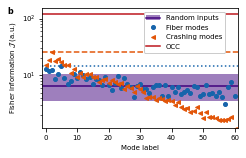

In [11]:
zf =1
fig, ax = plt.subplots(1,1, figsize=(zf*3.5,zf*2.2))
# ax2 = ax.twiny() 
ms = 4
# Random
# ln1, = ax2.plot(Frnd,'s',markersize=2, c=crnd)
ln1p = ax.fill_between(np.arange(-1,n_mod+1),np.max(Frnd), np.min(Frnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax.axhline(np.mean(Frnd), linestyle='-', c=crnd)
# Fiber modes
ln2, = ax.plot(np.arange(n_mod),Fmod,'o',markersize=ms, c=cmod)
ax.axhline(np.max(Fmod), linestyle=':', c=cmod)

# Crashing modes
ln3, = ax.plot(np.arange(n_mod),Fcrash[:n_mod],'<',markersize=ms, c=ccra)
ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)

# Fw4 = fisher(Xw4, TMs4modes, noise=noise)
# ax.plot(np.arange(n_mod),Fcrash_inw4[:n_mod],'>',markersize=5,  c='teal')
# ax.axhline(np.max(Fcrash_inw4), linestyle='--', c='teal')

# Fw4 = fisher(Xw4, TMs4modes, noise=noise)
# ln3, = ax2.plot(np.arange(n_mod),Fw4[:n_mod],'>',markersize=5,  c='teal')
# ax.axhline(np.max(Fcrash), linestyle='--', c=ccra)

# MIIS
ln4 = ax.axhline(Focc, c=cmii)

lns = [(ln1,ln1p),ln2,ln3,ln4]
lgd =ax.legend(lns,['Random inputs','Fiber modes',
    'Crashing modes','OCC'],
    bbox_to_anchor=(.5,.6), #bbox_to_anchor=(1.8,.5), 
    # loc=0, 
    facecolor='white',framealpha=1)
    
ax.set_xlabel('Mode label')
# ax2.set_xlabel('Random input label')
ax.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax.set_yscale('log')
ax.set_ylim(Focc *1e-2)
ax.set_xlim(-1.,n_mod-0.)
# t = ax.yaxis.get_offset_text()
# t.set_x(-10.1)
ax.text(-0.18,0.95, 'b', transform=ax.transAxes,  fontweight='bold')
plt.savefig(os.path.join(fig_path,'fish_pix.pdf'),bbox_inches='tight')

## 1.c Intensity correlations

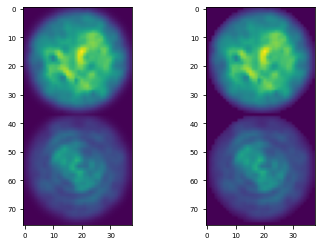

In [27]:
test_mask = getOutputFields(Xrnd[:100],TMlist4corr[0])

out_mask = get_disk_mask([N_out,N_out], 1.05*N_out//2, center=(N_out/2-1,N_out/2))
out_mask = np.concatenate((out_mask,out_mask), axis=0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(np.mean(np.abs(test_mask)**2,axis=0),(2*N_out,N_out)))
ax[1].imshow(out_mask*np.reshape(np.mean(np.abs(test_mask)**2,axis=0),(2*N_out,N_out)))

In [32]:
maskc = None # out_mask#
intc = True
rm=True #False
nrm=True

# The index 12 was chosen as the one giving coor=1
corr_mod = np.abs(get_corrVSdx(Xmod, TMlist4corr,TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_crash = np.abs(get_corrVSdx(Xcrash, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_rnd = np.abs(get_corrVSdx(Xrnd[:], TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))
corr_occ = np.abs(get_corrVSdx(Xocc, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))

<Figure size 252x158.4 with 0 Axes>

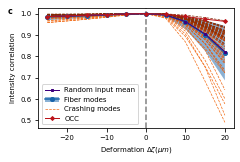

In [34]:
i0 = 7#center_TM_index-2#5#18
plt.figure(figsize = (3.5,2.2))
zf = 1
plt.figure(figsize = (zf*3.5,zf*2.2))
n_mod2p = n_mod#//3
n_cra2p = n_mod
ms = 4 #8
lw=0.7
dxp = (dx4corr[i0:] - dx4corr[12])*1000



plt.gca().axvline(0, c='gray', linestyle = 'dashed')
# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

ln3, = plt.plot(dxp, corr_crash[i0:,0], c=cmcra(0.6), ls='--', lw=lw,label='Crashing modes')
for i in range(1,n_cra2p):
    plt.plot(dxp, corr_crash[i0:,i], c=cmcra(0.6+0.4*i/n_cra2p), ls='--', lw=lw)#cmb(n_mod2p-i-1), ls='-')
# ln3, = plt.plot(dxp, corr_crash[i0:,2], color=cmcra(0.6), ls='--', lw=lw, marker='<',markersize=ms, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

# ln2, = plt.plot(dxp, corr_mod[i0:,0], color=cmmod(0.6), ls=':',label='Fiber modes')
# for i in range(1,n_mod2p):
#     plt.plot(dxp, corr_mod[i0:,i], color=cmmod(0.4+0.6*i/n_mod2p), ls=':')
ln2, = plt.plot(dxp, np.mean(corr_mod[i0:], axis=1), color=cmod, ls='-',marker='o', markersize=ms, label='Fiber modes')
ln2p = plt.fill_between(dxp, np.max(corr_mod[i0:], axis=1), np.min(corr_mod[i0:], axis=1),
    facecolor=cmod,alpha=0.5)
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

ln1, = plt.plot(dxp,np.mean(corr_rnd,axis=-1)[i0:],c=crnd,lw=1,markersize=0.6*ms,marker='s',label='Random modes')
# plt.fill_between(dxp, np.max(corr_rnd,axis=-1)[i0:], np.min(corr_rnd,axis=-1)[i0:],
#     facecolor=crnd,alpha=0.5)
ln4, = plt.plot(dxp,corr_occ[i0:],lw=1, c=cmii, markersize=0.7*ms, marker='D',label='BROAM')



all_min = plt.gca().get_ylim()[0]
plt.legend([ln1,(ln2p,ln2),ln3,ln4], ['Random input mean','Fiber modes',
    'Crashing modes','OCC'], loc='lower left')

plt.gca().text(-0.16,0.95, 'c', transform=plt.gca().transAxes,  fontweight='bold')
plt.xlabel('Deformation $\Delta \zeta (\mu m)$')
plt.ylabel('Intensity correlation')
# plt.title('Sensitivity to perturbation')
plt.savefig(os.path.join(fig_path,'Corr_vs_def.pdf'),bbox_inches='tight')

## 1.d Output fields

In [35]:
X4est = np.load(os.path.join(data_path,'Xestimate.npy'))

TMs4fieldplot = np.array([TMlist4corr[12], TMlist4corr[12+4]])
Yints4p = np.abs(getOutputFields(X4est[::-1], TMs4fieldplot))**2
Yints4p /= np.max(Yints4p)

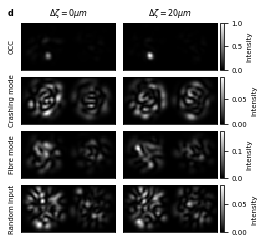

In [354]:
fig = plt.figure(figsize=(8,8))
titles = ['Random input', 'Fibre mode', 'Crashing mode', 'OCC']
"""
A grid of 2x2 images. Each row has its own colorbar.
"""
grid = AxesGrid(fig, 122,  # similar to subplot(122)
                nrows_ncols=(4, 2),
                axes_pad=0.10,
                label_mode="1",
                share_all=True,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="4%",
                cbar_pad="4%",
                )
# Z, extent = get_demo_image()
cmaps = ["spring", "winter"]
for i in range(4):
    curr_max = np.max(Yints4p[:,i])
    for j in range(2):
        ig = 2*i +j
    
        if j<1:
            im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
            grid[ig].text(-0.1,0.5, titles[-1-i],transform = grid[ig].transAxes,
                horizontalalignment='center',verticalalignment='center',fontsize=SMALL_SIZE,
                rotation=90)
        if j==1:
            im = grid[ig].imshow(horz_reshp(Yints4p[j,i]),vmin=0,vmax=curr_max,cmap=cmap_int,
                            interpolation='none')
            grid.cbar_axes[i].colorbar(im, label='Intensity')
        grid[ig].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
for cax in grid.cbar_axes:
    cax.toggle_label(True)
    # cax.axis[cax.orientation].set_label('Foo')
grid[0].text(-0.15,1.15, 'd', transform=grid[0].transAxes,  fontweight='bold')
grid[1].text(0.5,1.2, '$\Delta \zeta = 20 \mu m$',transform = grid[1].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)
grid[0].text(0.5,1.2, '$\Delta \zeta = 0 \mu m$',transform = grid[0].transAxes,
            horizontalalignment='center',verticalalignment='center',fontsize=MEDIUM_SIZE)

plt.savefig(os.path.join(fig_path,'fields_vs_def.pdf'),bbox_inches='tight')

# 2. Estimation figure

In [39]:
# Funciton for computing the estimation
def estimate_def(Imeas, Iref0, Ider, mui=1, mud=1):
    der = mud*Ider
    deformation = np.sum(der *(Imeas-mui * Iref0), axis=-1)/np.sum(der**2, axis=-1)
    return deformation

Load the data

In [40]:
I4der_3pts = np.load(os.path.join(data_path,'I4der_3pts.npy'))
Iest_vecs = np.load(os.path.join(data_path,'Iest_vecs.npy'))
amps = np.load(os.path.join(data_path,'amps4est.npy'))
pos4est = np.load(os.path.join(data_path,'pos4est.npy'))

Compute references, derivatives and estimations

In [41]:
I4der_means = np.mean(I4der_3pts, axis=1)
# Iders = (I4der_means[-1] - I4der_means[0])/(2*del_x)
ind_der_pm = 4#4
ind_der_0 = 4
Idiffs = (np.mean(Iest_vecs[ind_der_0+ind_der_pm,:,0], axis=0)-np.mean(Iest_vecs[ind_der_0-ind_der_pm,:,0], axis=0))
delx4der = (pos4est[ind_der_0+ind_der_pm]-pos4est[ind_der_0-ind_der_pm])
Iders = Idiffs/delx4der
Irefs0 = np.mean(Iest_vecs[ind_der_0,:], axis=0)

# Define the scaling factor
mui = (amps**2)[:,None,None]
mud = (amps**2)[:,None,None]

# Compute estimations
def_est_int = estimate_def(Iest_vecs, Irefs0, Iders, mui=1, mud=mud)

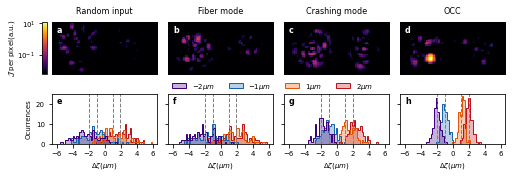

In [371]:
i_def_list = np.array([0,2,6,8])

nb_lb = [['a','b','c','d'],['e','f','g','h']]
labels = ['Random input', 'Fiber mode', 'Crashing mode', 'OCC']

fmax= np.max((np.abs(Idiffs)**2).ravel())
fmin = 0.5*fmax*(10**(-3))
Idiffs[np.abs(Idiffs)==0] = fmin**(1/2)

ld_list = np.linspace(1.4,0.6,len(i_def_list))
ind_amp = 3

fig, axs = plt.subplots(2,4,figsize=(7.,2.3))
chist = [crnd, cmod, ccra, cmii]
alpha = 0.3


sca_fac = Focc/np.sum(np.abs(Idiffs[3])**2)

cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

lw=1
target_def_list = pos4est[i_def_list]  - pos4est[4]
xmin = 1000*target_def_list[0]-4
xmax = 1000*target_def_list[-1]+4
bins = np.linspace(xmin,xmax,60)

for ip in range(4):
    pl_fish = axs[0,ip].matshow(sca_fac*(np.abs(horz_reshp(Idiffs[ip]))**2),
                        norm=colors.LogNorm(vmin=sca_fac*fmin, vmax=sca_fac*fmax),
                        cmap=cmap_fish,
                        interpolation='none')

    axs[0,ip].axis('off')
    axs[0,ip].set_ylabel(labels[ip])
    axs[0,ip].text(0.5,1.2, labels[ip],transform = axs[0,ip].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    
    if ip>0:
        axs[1,ip].axes.yaxis.set_ticklabels([])

    axs[1,ip].set_ylim(0,25)
    
    axs[1,ip].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = 1000*def_est_int[i_def_list,:,ind_amp,ip].T
    axs[1,ip].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[1,ip].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')
    
    for n, i_def in enumerate(i_def_list):

        axs[1,ip].axvline(x=1000*target_def_list[n], c='gray',linewidth=lw, ls='--')
    
    axs[1,ip].set_aspect(1/4)
    axs[1,ip].set_xticks(np.arange(-6,8,2))
    axs[0,ip].text(0.05,0.8,nb_lb[0][ip], transform=axs[0,ip].transAxes, color='w', fontweight='bold')
    axs[1,ip].text(0.05,0.8,nb_lb[1][ip], transform=axs[1,ip].transAxes,  fontweight='bold')
    # axs[ind_p].text(-0.2,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')
axs[1,0].set_ylabel('Ocurrences')

handles = [matplotlib.patches.Rectangle((0,0),.1,.1,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["$-2\mu m$","$-1\mu m$", "$1\mu m$",'$2\mu m$']
fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=4, loc=(0.33,0.47), frameon=False)

cb_width =0.01
cb_height = 0.315
cbar_ax2 = fig.add_axes([-0.019, 0.56, cb_width, cb_height])
cbar2=fig.colorbar(pl_fish, cax=cbar_ax2, orientation='vertical',label='$\mathcal{J}$ per pixel(a.u.)')
cbar_ax2.yaxis.set_ticks_position('left')

cbar_ax2.get_yaxis().labelpad = -40
# cbar2.set_label('$\mathcal{J}_n$ (a.u.)', rotation=90)

plt.subplots_adjust(left=0, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

plt.savefig(os.path.join(fig_path,'Est_def.pdf'),bbox_inches='tight',dpi=400)

# 3. Reaching the precision limit

Change of basis to speed things up

In [126]:
from scipy.linalg import orth

In [234]:
vecs_new_basis = np.zeros((2*N_out**2,n_mod*2), dtype=complex)
for i, tm in enumerate(TMs4modes[::2]):
    udef, sdef, vhdef = np.linalg.svd(tm)
    vecs_new_basis[:,n_mod*i:n_mod*(i+1)] = udef[:,:n_mod]

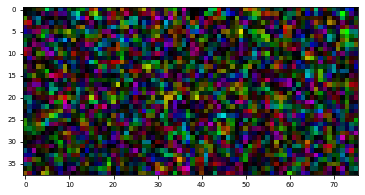

In [240]:
u_nb = orth(vecs_new_basis)
plt.imshow(colorize(horz_reshp(u_nb[:,-1])))
TMs_nb= u_nb.T.conj() @ TMs4modes

Compute Fisher information in optimal output basis for random inputs and fiber modes:

In [242]:
mofish = lambda mo : np.sum(np.abs(mo[1])**2, axis=-1)

In [243]:
Fmo_rnd = []
for ind in range(n_rnd//50):
    _, vals_rnd = get_moim(Xrnd[ind*50:(ind+1)*50], TMs_nb[::2])
    Fmo_rnd += np.sum(np.abs(vals_rnd)**2, axis=-1).tolist()

MOmod = get_moim(Xmod, TMs_nb[::2])
Fmo_mod = mofish(MOmod)

Compute fourth-order crashing modes

In [244]:
W4th_tensor = get_W4(TMs_nb.astype(np.csingle))
uw4s, sw4 = hosvd(W4th_tensor)
Xw4 = uw4s[3].T
MOw4 = get_moim(Xw4, TMs_nb[::2])
Fmo_w4 = mofish(MOw4)

Compute the optimal channel

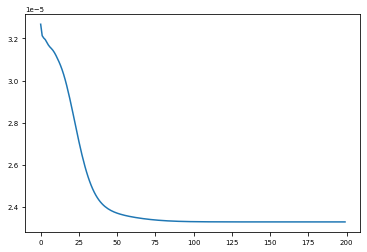

In [245]:
optw4_seeds = [Xw4[i] for i in range(10)]
Flim, Xlim, evol, nseed = get_lim(optw4_seeds, TMs_nb[::2], n_iter=200)
plt.plot(evol)

Compute optimal with single output projection

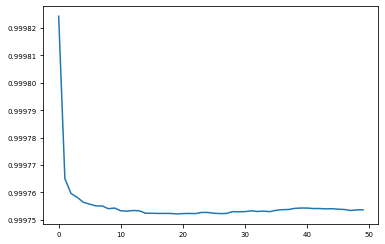

In [246]:
als4_seeds = [[uw4s[0][:,0,None],uw4s[1][:,0,None],uw4s[2][:,0,None],uw4s[3][:,0,None]]]
Fb1out, Xb1out, evol_als, nseed = get_best1out(als4_seeds, TMs_nb[::2], W4th_tensor,n_iter=50)
plt.plot(evol_als)

## Plot figure

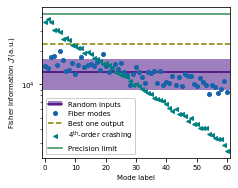

In [285]:
fig, ax1 = plt.subplots(1,1, figsize=(3.2, 2.5), layout="constrained")


# Best pix
# l0 = ax1.axhline(Focc, linestyle=':', color='gray')

# Random
# ln1, = ax1t.plot(Fmo_rnd,'s',markersize=2, c=crnd)
ln1p = ax1.fill_between(np.arange(-1,n_mod+1),np.max(Fmo_rnd), np.min(Fmo_rnd),
    facecolor=crnd,alpha=0.5)
ln1 = ax1.axhline(np.mean(Fmo_rnd), linestyle='-', c=crnd) 

# Fiber modes
ln2, = ax1.plot(np.arange(n_mod), Fmo_mod,'o',markersize=ms, c=cmod)
# ax.axhline(np.max(Fmo_mod), linestyle=':', c=cmod)

# best 1 out
ln3 = ax1.axhline(Fb1out, c='olive', linestyle='--')

# sing W4
ln5, = ax1.plot(np.arange(n_mod), Fmo_w4,'<',markersize=ms, c='teal')
ln6 = ax1.axhline(Flim, c='seagreen')

# lns = [l0,(ln1p,ln1),ln2,ln3,ln5,ln6]
lns = [(ln1p,ln1),ln2,ln3,ln5,ln6]
lgd =ax1.legend(lns,[#'Best pixel',
    'Random inputs','Fiber modes',
    'Best one output','4${}^\mathregular{th}$-order crashing','Precision limit'],
    # bbox_to_anchor=(1.,.5), #bbox_to_anchor=(1.8,.5), 
    loc=3, facecolor='white',framealpha=1)
    
ax1.set_xlabel('Mode label')
# ax1.set_xlabel('Random input label')
ax1.set_ylabel('Fisher information $\mathcal{J}$ (a.u.)')
ax1.set_yscale('log')
ax1.set_xlim(-1.,n_mod-0.)
# ax1.text(-0.18,0.95, nb_lb[0], transform=ax1.transAxes,  fontweight='bold')
plt.savefig(os.path.join(fig_path,'Precision_lim.pdf'),bbox_inches='tight',dpi=400)

# 4. Comparing fields close to the limit

Compute fields

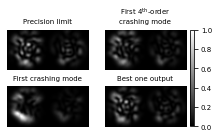

In [286]:
Ysbest = np.abs(getOutputFields(np.array([Xlim,Xw4[0],Xcrash[0],Xb1out]), TMs4modes[1]))**2
Ysbest /= np.max(Ysbest)
fig, axs = plt.subplots(2,2,figsize=(3.2,0.6*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    pl_int = ax.imshow(horz_reshp(Ysbest[i]),cmap=cmap_int, vmin=0,vmax=1)
    ax.axis('off')

cb_width =0.015
cb_height = 0.7
cbar_ax2 = fig.add_axes([0.92, 0.155, cb_width, cb_height])
cbar2=fig.colorbar(pl_int, cax=cbar_ax2, orientation='vertical')
# cbar_ax2.yaxis.set_ticks_position('left')
plt.savefig(os.path.join(fig_path,'field_comp.pdf'),bbox_inches='tight',dpi=400)

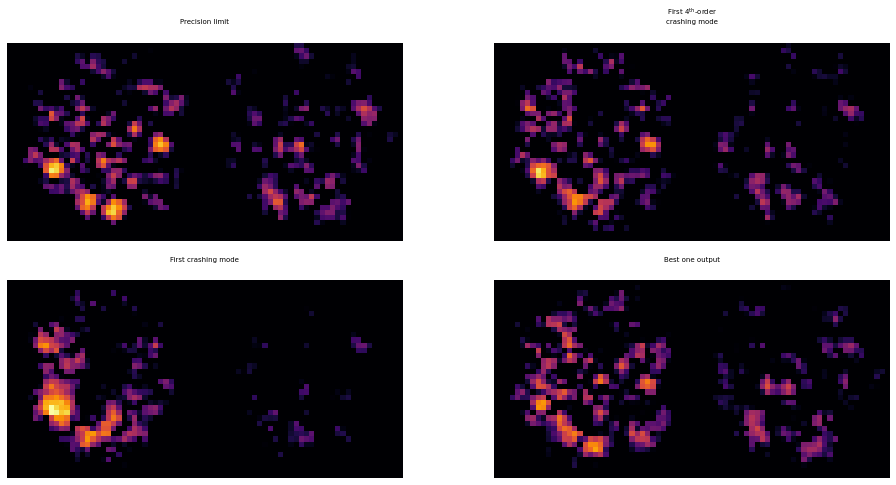

In [295]:
Ysbest = fisherPerMode(np.array([Xlim,Xw4[0],Xcrash[0],Xb1out]), TMs4modes[::2])
Ysbest /= np.max(Ysbest)
Ysbest[Ysbest<=0]=10e-9
fig, axs = plt.subplots(2,2,figsize=5*np.array([3.2,0.5*3.2]))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.matshow(horz_reshp(Ysbest[i]),
                norm=colors.LogNorm(vmin=10e-3, vmax=1),
                                    cmap=cmap_fish,
                                    interpolation='none')
    ax.axis('off')

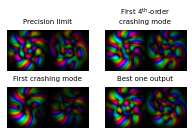

In [296]:
Ysbest =getOutputFields(np.array([Xlim,Xw4[0],Xcrash[0],Xb1out]), TMs4modes[1])
Ysbest /= np.max(np.abs(Ysbest))
fig, axs = plt.subplots(2,2,figsize=(3.2,0.6*3.2))
titles = ['Precision limit', 'First 4${}^\mathregular{th}$-order\ncrashing mode', 
    'First crashing mode','Best one output']
for i, ax in enumerate(axs.ravel()):
    ax.set_title(titles[i])
    ax.imshow(colorize(horz_reshp(Ysbest[i])))

    ax.axis('off')

In [297]:
np.abs(seq_cpx_corr(Ysbest,Ysbest[0]))

array([1.        , 0.90928827, 0.71601741, 0.91665988])

In [298]:
Ys_rnd  = getOutputFields(np.array(Xrnd), TMs4modes[1])
Ys_rnd /= np.max(np.abs(Ys_rnd))
np.mean(np.abs(seq_cpx_corr(Ys_rnd,Ysbest[0])))

0.1218698028584042

In [299]:
np.abs(seq_cpx_corr(Ys_rnd[:20],Ysbest[0]))

array([0.09280933, 0.05573902, 0.06928105, 0.11076922, 0.13155375,
       0.20912272, 0.13849386, 0.10058687, 0.11774188, 0.15038513,
       0.11998876, 0.19395487, 0.07805028, 0.06433818, 0.12836155,
       0.0479367 , 0.14978806, 0.13332765, 0.11887908, 0.18864922])

# 5. Blind estimation

In [301]:
udef, sdef, vhdef = np.linalg.svd(TMpix)
TMs_modes = udef[:,:n_mod].T.conj() @ TMs4modes

n_moims = n_mod
sing_moims = uw4s[0][:,:n_moims]/(np.sum(np.abs(uw4s[0][:,:n_moims])**2,axis=0, keepdims=True))**(1/2)
TMs_hosvd = sing_moims.T.conj() @ TMs_nb

In [302]:
# n_rnd = 10000
# Xrnd = normalizevecs(rnd_cpx_disk((n_rnd,n_mod)))
Frnd_pix = fisher(Xrnd, TMs4modes, noise=noise)
Frnd_mod = fisherPerMode(Xrnd, TMs_modes, noise=noise)
# Frnd_svd = fisherPerMode(Xrnd, TMs_svd, noise=noise)
Frnd_hosvd = fisherPerMode(Xrnd, TMs_hosvd, noise=noise)

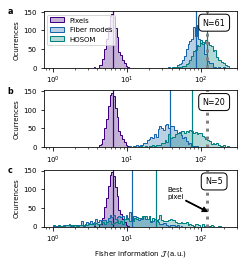

In [351]:
nb_lb = ['a','b','c','d']
Fsrnd = np.array([Frnd_mod, Frnd_hosvd])
lwvl=3
zf=1
lbs = ['Pixels', 'Fiber modes', 'HOSOM']
chist = [crnd, cmod, 'teal', cmii]#ccra, cmii]
bins = np.geomspace(1., Fsrnd.ravel().max(), 100)
alpha = 0.3
lw=1

fig, axs = plt.subplots(3,1,figsize=(zf*3.15,zf*3.5))

for ind_p, n_outs in enumerate([61, 20, 5]):
    for i, d in enumerate([Frnd_pix, Frnd_mod, Frnd_hosvd]):
        if i != 0:
            vals_sort = np.argsort(np.mean(d, axis=0))
            dh=np.sum(d[:,vals_sort[-n_outs:]],axis=-1)
        else:
            dh=d
        axs[ind_p].hist(dh, bins, color=chist[i], histtype='step',lw=lw)
        axs[ind_p].hist(dh, bins, color=chist[i], alpha=alpha,  histtype='stepfilled')
            
        axs[ind_p].axvline(x=np.mean(dh), c=chist[i],linewidth=1.2*lw)

    axs[ind_p].set_xscale('log')
    axs[ind_p].axvline(x=Focc, c='gray',linestyle=':',linewidth=lwvl)
    axs[ind_p].set_ylabel('Ocurrences')
    
    axs[ind_p].text(-0.19,0.95,nb_lb[ind_p], transform=axs[ind_p].transAxes, fontweight='bold')
    axs[ind_p].text(0.88,0.75,'N='+str(n_outs), fontsize=MEDIUM_SIZE, 
        horizontalalignment='center', transform = axs[ind_p].transAxes,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
cf = []
for i in range(3):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]
handles = [matplotlib.patches.Rectangle((0,0),.1,.1,color=cf[i],ec=chist[i]) for i in range(3)]
axs[0].legend(handles, lbs, fontsize=SMALL_SIZE, ncol=1, loc='upper left')#, frameon=False)
axs[2].annotate('Best\npixel', xy=(Focc, 40), xytext=(45, 75), horizontalalignment='center',
            fontsize=SMALL_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))
# axs[2].annotate('Best\npixel', xy=(Focc, 300), xytext=(40, 650), horizontalalignment='left',
#             fontsize=SMALL_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))
axs[2].set_xlabel('Fisher information $\mathcal{J}$ (a.u.)')

plt.tight_layout(pad=0., w_pad=0., h_pad=.02)
plt.savefig(os.path.join(fig_path,'Best_out_basis.pdf'),bbox_inches='tight')

# Suplementary Figures

## S1. Choosing the input modes: SVD at rest

In [ ]:
# load TM in the pixel basis 
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))

In [ ]:
u, s, vh = np.linalg.svd(TMpix)
fig,ax = plt.subplots(1, 1)
ax.semilogy((s[:int(n_mod*1.5)]/s[0])**2,'+')
ax.axvline(n_mod-.5,c='r')
ax.axhline((s[n_mod-1]/s[0])**2,c='gray')
ax.grid(True)

## S. Loaction for the central deformation

In [ ]:
center_TM_index = 11

fig,ax = plt.subplots(1, 1)
ax.plot(dx4corr,fidelity(TMlist4corr,TMlist4corr[0]))
ax.plot(dx4corr,fidelity(np.abs(TMlist4corr),np.abs(TMlist4corr[0])),c='r')
# Maybe these need to be adjusted using the correlation between TMlist4corr and TM4modes
ax.axvline(dx4modes[1],c='g')
ax.axvline(dx4modes[0],c='gray')
ax.axvline(dx4modes[2],c='gray')

## S2. Crashing modes from higher-order eigenvalue problem

In [ ]:
from numba import jit
@jit(nopython=True)
def get_inW4(w3):
    m = w3.shape[-1]
    inw4 = np.empty([m]*4, dtype=np.complex128)
    for i in range(m):
        for j in range(m):
            for k in range(m):
                for l in range(m):
                    inw4[i,j,k,l] = np.sum((w3[:,i,j]*w3[:,k,l]), axis=0)
    return inw4

In [ ]:
inW4 = get_inW4(W_ten)
us_hosvd_inw4 = get_HOSvec(inW4,2)
Xcrash_inw4 = us_hosvd_inw4.T
Fcrash_inw4 = fisher(Xcrash_inw4, TMs4modes)

In [ ]:
Yints_inw4 = np.abs(getOutputFields(Xcrash_inw4, TMs4fieldplot))**2
Yints_inw3 = np.abs(getOutputFields(Xcrash, TMs4fieldplot))**2

Compare output intensities

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ind_c = 0
ax[0].imshow(horz_reshp(Yints_inw3[0,ind_c]),vmin=0,cmap=cmap_int,
                            interpolation='none')
ax[1].imshow(horz_reshp(Yints_inw4[0,ind_c]),vmin=0,cmap=cmap_int,
                            interpolation='none')

Compare coefficients

In [ ]:
plt.plot(np.abs(Xcrash[2]))
plt.plot(np.abs(Xcrash_inw4[3]))

Correlations

In [ ]:
corr_crash_inw4 = np.abs(get_corrVSdx(Xcrash_inw4, TMlist4corr, TMlist4corr[12], mask=maskc,remove_mean=rm,inten=intc,normalize=nrm))

## S3. Unnormalized correlation curves

In [ ]:
def get_IchgVSdx(Xs, TMs, TMref, mask=None, remove_mean=False):
    Ydx = getOutputFields(Xs,TMs)
    Yref = getOutputFields(Xs,TMref)
    
    Ydx = np.abs(Ydx)**2
    Yref = np.abs(Yref)**2
    sh = Ydx.shape

    chg = np.sum((Yref-Ydx)**2, axis=-1)
    
    return chg

In [ ]:
chg_mod = get_IchgVSdx(Xmod, TMlist4corr,TMlist4corr[12])
chg_crash = get_IchgVSdx(Xcrash, TMlist4corr, TMlist4corr[12])
chg_rnd = get_IchgVSdx(Xrnd, TMlist4corr, TMlist4corr[12])
chg_occ = get_IchgVSdx(Xocc, TMlist4corr, TMlist4corr[12])

In [ ]:
i0 = 8#center_TM_index-2#5#18
plt.figure(figsize = (8,6))
n_mod2p = n_mod#//3
n_cra2p = n_mod

dxp = (dx4corr[i0:] - dx4corr[12])*1000

fun_scale = lambda x : x**(1/2) 

for i in range(n_mod2p):
    plt.plot(dxp, fun_scale(chg_mod[i0:,i]), color=cmmod(0.4+0.6*i/n_mod2p), ls='--')


# plt.plot(dxp, corr_crash[i0:im,0], color=cmr(n_mod2p), ls='-', label='Crashing modes')

for i in range(n_cra2p):
    plt.plot(dxp, fun_scale(chg_crash[i0:,i]), c=cmcra(0.6+0.4*i/n_cra2p), ls=':')#cmb(n_mod2p-i-1), ls='-')
plt.plot(dxp, fun_scale(chg_crash[i0:,2]), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')
# plt.plot(dxp, np.mean(corr_crash[i0:,:], axis=-1), color=cmcra(0.6), ls='-', marker='<',markersize=8, label='Crashing modes')

plt.plot(dxp, fun_scale(chg_mod[i0:,np.argmax(Fmod)]), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')
# plt.plot(dxp, np.mean(corr_mod[i0:,:], axis=-1), color=cmod, ls='-',marker='o', markersize=8, label='Fiber modes')

plt.plot(dxp,fun_scale(np.mean(chg_rnd,axis=-1)[i0:]),c=crnd,markersize=8,marker='s',label='Random wavefronts')

plt.plot(dxp,fun_scale(chg_occ[i0:]),lw=3, c=cmii, markersize=8, marker='D',label='MIIS')

all_min = plt.gca().get_ylim()[0]
plt.gca().axvline(0, c='gray', linestyle = 'dashed')
plt.legend(loc=0)
# plt.yscale('log')
plt.xlabel('$\Delta x (\mu m)$')
plt.ylabel('$\sqrt{\sum_n (\Delta I_n)^2} $')
plt.title('Sensitivity to perturbation')

## S. Camera background for reference during estimation

In [ ]:
plt.imshow(I4der_means[0,2].reshape(2*N_out,N_out),cmap=cmap_int)

In [70]:
Iders.shape

(4, 2888)

In [68]:
Irefs0.shape

(5, 4, 2888)

In [69]:
Iest_vecs.shape

(9, 100, 5, 4, 2888)

In [71]:
amps

array([1.  , 0.5 , 0.25, 0.2 , 0.1 ])

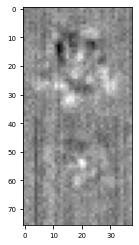

In [79]:
plt.imshow((Irefs0[3,1]-amps[3]**2*Irefs0[0,1]).reshape(2*N_out,N_out),cmap=cmap_int)

In [87]:
amps

array([1.  , 0.5 , 0.25, 0.2 , 0.1 ])

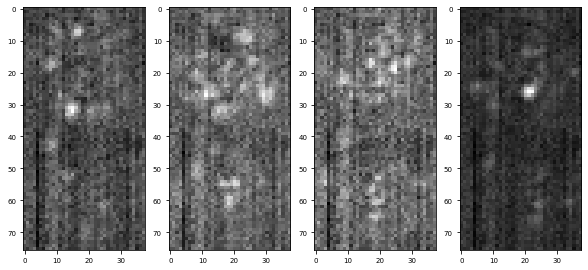

In [93]:
ind_amp1 = 3
ind_amp2 = 4
fig, axs = plt.subplots(1,4, figsize=(10,5))
for ind_f in range(4):
    axs[ind_f].imshow((amps[ind_amp1]**2*Irefs0[ind_amp2,ind_f]-amps[ind_amp2]**2*Irefs0[ind_amp1,ind_f]).reshape(2*N_out,N_out),cmap=cmap_int)

In [95]:
Irefs0.shape

(5, 4, 2888)

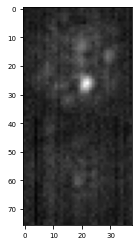

In [94]:
plt.imshow(np.mean(Irefs0[3],axis=0).reshape(2*N_out,N_out),cmap=cmap_int)